In [ ]:
# TODO deque(maxlen, )
from LossHistory import LossHistory
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

import random
import gym
import numpy as np
from collections import deque
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, ELU, Activation, Conv2D, MaxPooling2D
from keras.models import Model, load_model


from skimage.transform import resize
from skimage.color import rgb2gray

# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

EPISODES = 100

class DQNAgent:
    def __init__(self, state_size, action_size, loss_history):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=6000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.dilation_rate = 1
        self.h = []
        self.target_shape = (64,64)
        self.loss_history = loss_history
        self.model = self._build_model()

        

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        input_img = Input(shape=(self.target_shape[0], self.target_shape[1], 1))  # adapt this if using `channels_first` image data format

        x = Conv2D(16, (8, 8), activation='relu', padding='same', dilation_rate=self.dilation_rate)(input_img)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (4, 4), activation='relu', padding='same', dilation_rate=self.dilation_rate)(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Flatten()(x)
        x = Dropout(0.2)(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dense(3, activation='linear')(x)

        model = Model(input_img, x)
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice([0,1,2], 1)
        act_values = self.model.predict(state)
        # print(np.argmax(act_values))
        return np.argmax(act_values)  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            if done:
                target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)))
            target_f = self.model.predict(state)
            target_f[0, action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0, callbacks = [loss_history])
            self.h.append(loss_history.batch_loss)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def fi(self, observation):
        observation = observation[34:194,:,:]
        observation = resize(observation, self.target_shape, anti_aliasing=True)
        observation = rgb2gray(observation).reshape(self.target_shape[0],self.target_shape[1],1)
        return observation

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


if __name__ == "__main__":
    env = gym.make("Pong-v0")
    state_size = (64,64)
    action_size = 3
    loss_history = LossHistory()
    agent = DQNAgent(state_size, action_size, loss_history)
#     agent.load("Pong-v0.h5")
    done = False
    batch_size = 128

    for e in range(EPISODES):
        state = env.reset()
        state = agent.fi(state)[None,:,:,:]
        for time in range(2000):
#             env.render()
            if time % 400 == 0:
                print('time:', time, 'mean loss:', np.mean(agent.h))
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action + 1)
            reward = reward if not done else -10 ############################################!!!!!!!!!!!!!!!!
            next_state = agent.fi(next_state)[None,:,:,:]
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, time, agent.epsilon))
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        if e % 2 == 0:
            namestr = "Pong-v0.h5" + str(np.mean(agent.h))
            agent.save(namestr)
            print('SAVING AGENT WEIGHTS', 'LOSS:', np.mean(agent.h))
plt.plot(agent.h)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        1040      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
__________

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


time: 400 mean loss: 4139.818
time: 800 mean loss: 7313.203
SAVING AGENT WEIGHTS LOSS: 38547.01
time: 0 mean loss: 38547.01
time: 400 mean loss: 74918.664
time: 800 mean loss: 91830.266
episode: 1/100, score: 1009, e: 0.01
time: 0 mean loss: 92377.56
time: 400 mean loss: 89839.875
time: 800 mean loss: 86333.055
episode: 2/100, score: 1015, e: 0.01
SAVING AGENT WEIGHTS LOSS: 85465.984
time: 0 mean loss: 85465.984
time: 400 mean loss: 82986.17
time: 800 mean loss: 88621.81
episode: 3/100, score: 1009, e: 0.01
time: 0 mean loss: 117816.21
time: 400 mean loss: 254168.08
time: 800 mean loss: 374975.38
episode: 4/100, score: 1013, e: 0.01
SAVING AGENT WEIGHTS LOSS: 417545.7
time: 0 mean loss: 417545.7
time: 400 mean loss: 461324.53
time: 800 mean loss: 471204.38
episode: 5/100, score: 1013, e: 0.01
time: 0 mean loss: 469775.3
time: 400 mean loss: 461677.1
time: 800 mean loss: 446543.66
episode: 6/100, score: 1013, e: 0.01
SAVING AGENT WEIGHTS LOSS: 437824.47
time: 0 mean loss: 437824.47
time

In [ ]:
2+2

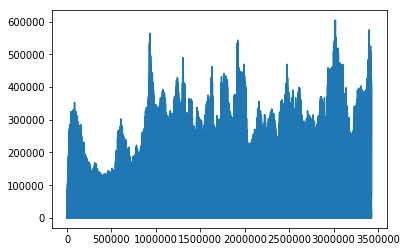

In [8]:
import matplotlib.pyplot as plt
plt.plot(agent.h)